In [1]:
from __future__ import print_function, division
from collections import OrderedDict
import uproot
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

%matplotlib inline
from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [3]:
import pickle, gzip
with gzip.open("final.pkl.gz", "rb") as fin:
    final = pickle.load(fin)

In [4]:
final

<Hist (dataset,gencat,doubleB,msd,ptj) instance at 0x1051c0d10>

In [5]:
process = hist.Cat("process", "Process", sorting='placement')
process_cats = ("dataset", "gencat")
process_map = OrderedDict()
process_map["QCD in V"] = ("*", 0)
process_map["Zqq"] = ("ZJetsToQQ_HT*", 1)
process_map["Zcc"] = ("ZJetsToQQ_HT*", 2)
process_map["Zbb"] = ("ZJetsToQQ_HT*", 3)
process_map["Wqq"] = ("WJetsToQQ_HT*", 1)
process_map["Wcs"] = ("WJetsToQQ_HT*", 2)

final_mapped = final.group(process, process_cats, process_map)

In [6]:
# to_plot = final_mapped.project("doubleB", slice(0.8, 1.)).project("ptj", slice(450,600))
to_plot = final_mapped[:,0.8:,:,450:500].sum("doubleB", "ptj")
to_plot.fill(process="Sandwich", msd=np.random.normal(loc=150, scale=10, size=200), weight=np.ones(200)*.05)

bc = to_plot.sum("process").axis("msd").centers()
bv = to_plot.sum("process").values()[()]
bvp = np.random.poisson(bv)
data = np.repeat(bc, bvp)
data_plot = to_plot.copy(content=False)
data_plot.fill(process="Pseudodata", msd=data)

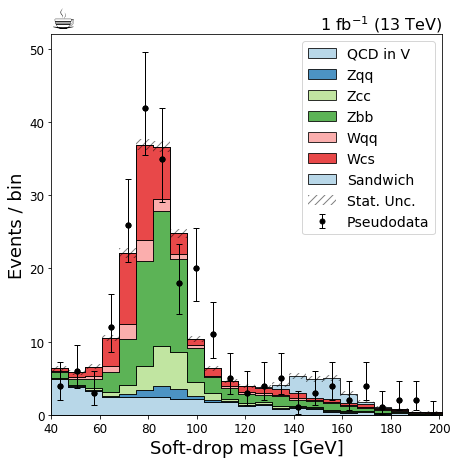

In [8]:
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fig, ax = plt.subplots(1, 1, figsize=(7,7))
# http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 0.8}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
plot.plot1d(ax, to_plot, "msd", stack=True, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
data_err_opts = {'linestyle':'none', 'marker': '.', 'markersize': 10., 'color':'k', 'elinewidth': 1, 'emarker': '_'}
ret = plot.plot1d(ax, data_plot, "msd", error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
leg = ax.legend()
coffee = plt.text(0., 1., u"☕", fontsize=28, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
lumi = plt.text(1., 1., r"1 fb$^{-1}$ (13 TeV)", fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)


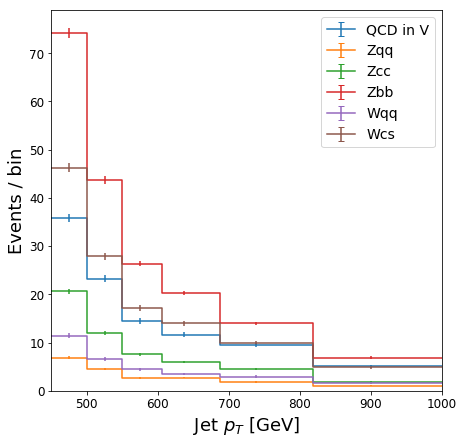

In [9]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,7))
to_plot_2 = final_mapped[:,0.8:,:,450:].sum("doubleB", "msd")
plot.plot1d(ax2, to_plot_2, "ptj", error_opts={})
ax2.autoscale(axis='x', tight=True)
ax2.set_ylim(0, None)
leg2 = ax2.legend()

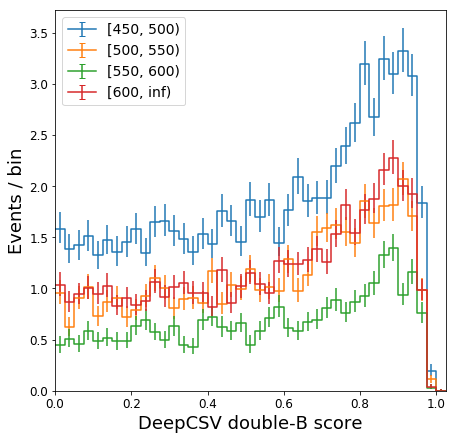

In [10]:
fig2, ax2 = plt.subplots(1,1, figsize=(7,7))
to_plot_2 = final_mapped["Zcc",:,:,:600].sum("msd", "process")
plot.plot1d(ax2, to_plot_2, "doubleB", overflow='over', overlay_overflow='over', error_opts={})
ax2.autoscale(axis='x', tight=True)
ax2.set_ylim(0, None)
leg2 = ax2.legend()

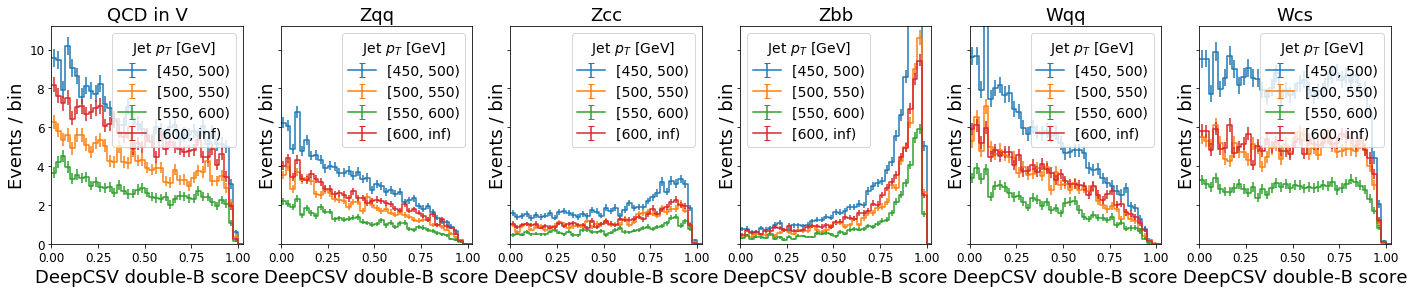

In [12]:
to_plot_3 = final_mapped[...,:600].sum("msd")
fig, axes = plot.plotgrid(to_plot_3, col="process", overlay="ptj", overflow='over', overlay_overflow='over', error_opts={})